In [1]:
pip install pygithub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
from math import isnan
import numpy as np
import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from github import Github
import datetime
from datetime import datetime, date, timedelta
import time
from dateutil.relativedelta import relativedelta


In [3]:
# change since_date to change how far back to go for data
# 2 years worth of data
since_date = datetime.now() - relativedelta(days=2*365)
print(since_date)

2021-06-17 00:07:02.387865


In [4]:
# get data from 5 repos
# Note: 'SebastianM' from the assignment renamed their account to 'sebholstein'
repos=["angular/angular", "angular/material", "angular/angular-cli", "sebholstein/angular-google-maps", "d3/d3"]

# unit testing repos
# repos=["sebholstein/angular-google-maps", "d3/d3"]

In [5]:
# gh access token goes here
g = Github("access token")

In [6]:
# get Github data for issues, pulls, releases, branches, contributors, and forks
def getReposData():
    for repo in repos:
        repository = g.get_repo(repo)
        print('repo:', repo)

        # get issues
        for issue in repository.get_issues(state='all', since=since_date, sort='created'):
            if issue.created_at >= since_date:
                issues.append({'repository': repo,
                               'issue': issue,
                               'issue.closed_at': issue.closed_at,
                               'issue.created_at': issue.created_at})
                print(repository, issue, issue.closed_at, issue.created_at)

        # get pulls
        for pull in repository.get_pulls(state='all', sort='newest'):
            if pull is not None and pull.created_at >= since_date:
                pulls.append({'repository': repo,
                              'pull': pull,
                              'pull.created_at': pull.created_at})
                print(repository, pull, pull.created_at)


        # # get releases
        # for release in repository.get_releases():
        #     if release is not None and issue.created_at >= since_date:
        #         releases.append({'repository': repo,
        #                          'release': release})
        #         print(repository, release)

        # # get branches
        # for branch in repository.get_branches():
        #     commit = repository.get_commit(branch.commit.sha)
        #     if branch is not None and issue.created_at >= since_date:
        #         branches.append({'repository': repo,
        #                          'branch': branch})
        #         print(repository, branch)

        # # get contributors
        # for contributor in repository.get_stats_contributors():
        #     author_id = contributor.author.id
        #     contributors.append({'author_id': author_id})

        # # get weeks
        #     for week in contributor.weeks:
        #         weeks.append({'repository': repo,
        #                       'contributor': contributor,
        #                       'week': week})
        #         print(repository, contributor, week)

        # get forks for each repo
        for fork in repository.get_forks():
            if fork.created_at >= since_date:
                fork_data.append({'repository': repo,
                                  'fork_repo': fork,
                                  'created_at': fork.created_at})
                print(repo, fork, fork.created_at)

        print(repo, repository.forks_count)


In [7]:
# initiliaze lists for storing data
issues = []
pulls = []
fork_data = []
getReposData()

Streaming output truncated to the last 5000 lines.
Repository(full_name="angular/angular-cli") PullRequest(title="fix(@angular-devkit/build-angular): detect `tailwind.config.cjs` as valid tailwindcss configuration", number=23240) 2022-05-27 08:28:04
Repository(full_name="angular/angular-cli") PullRequest(title="fix(@angular/cli): support silent package installs with Yarn 2+", number=23242) 2022-05-27 13:54:12
Repository(full_name="angular/angular-cli") PullRequest(title="fix(@angular-devkit/schematics): support ignore scripts package installs with Yarn 2+", number=23243) 2022-05-27 15:18:21
Repository(full_name="angular/angular-cli") PullRequest(title="build: update angular", number=23244) 2022-05-28 05:51:33
Repository(full_name="angular/angular-cli") PullRequest(title="run e2e tests in isolated child processes", number=23245) 2022-05-28 08:11:25
Repository(full_name="angular/angular-cli") PullRequest(title="fix(@angular-devkit/core): address Node.js `DEP0128` warning", number=23248) 

In [8]:
# df for repo issues
issues_df = pd.DataFrame(issues)
# replace n/a with null
issues_df.dropna(inplace=True)
print(issues_df.isna().sum())
print(len(issues))
print(len(pulls))

repository          0
issue               0
issue.closed_at     0
issue.created_at    0
dtype: int64
12098
7899


In [9]:
issues_df

,repository,issue,issue.closed_at,issue.created_at
3,angular/angular,"Issue(title=""Get element inside ng-template."",...",2023-06-16 11:06:27,2023-06-16 09:50:18
7,angular/angular,"Issue(title=""RuntimeError: NG0205 error on sub...",2023-06-16 08:48:58,2023-06-16 07:54:42
14,angular/angular,"Issue(title=""build: update angular dev-infra p...",2023-06-16 08:51:16,2023-06-15 13:51:40
15,angular/angular,"Issue(title=""query params subscription fires t...",2023-06-15 14:15:20,2023-06-15 12:43:00
23,angular/angular,"Issue(title=""docs: release notes for the v16.1...",2023-06-14 16:44:35,2023-06-14 16:44:07
...,...,...,...,...
12093,d3/d3,"Issue(title=""Why is the mouseleave event trigg...",2021-07-29 08:04:49,2021-07-29 08:01:25
12094,d3/d3,"Issue(title=""D3 for iOS (swift) ?"", number=3517)",2021-07-22 17:35:53,2021-07-22 06:18:18
12095,d3/d3,"Issue(title=""how to use in miniprogram"", numbe...",2021-07-14 02:59:34,2021-07-14 02:58:36
12096,d3/d3,"Issue(title=""Wiki latest link error"", number=3...",2021-07-04 17:16:02,2021-07-04 16:57:39


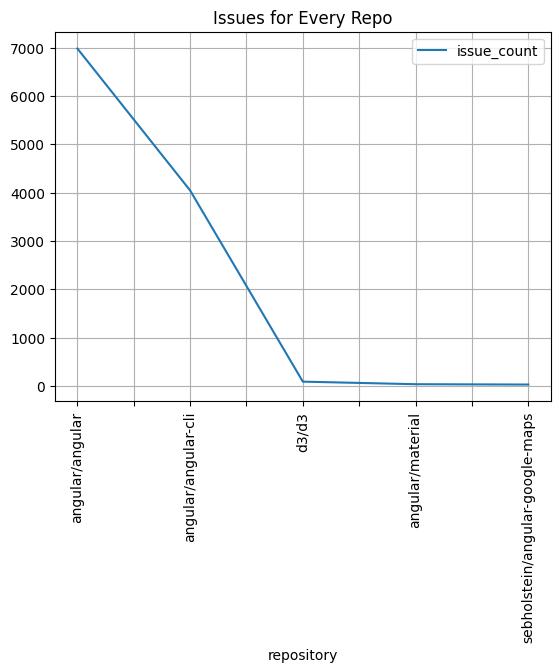

In [10]:
# Create A Line Chart to plot the issues for every Repo
# count the number of issues per repo
issues_count = issues_df.value_counts(['repository'])

#convert from series to df
issues_count_df = issues_count.reset_index()

issues_count_df.head()

# rename columns
issues_count_df.columns = ['repository', 'issue_count']

# show plot
issues_count_df.plot(kind='line', x='repository', y='issue_count', title='Issues for Every Repo')
plt.xticks(rotation='vertical')
plt.grid()
plt.show()

In [1]:
issues_count_df

NameError: name 'issues_count_df' is not defined

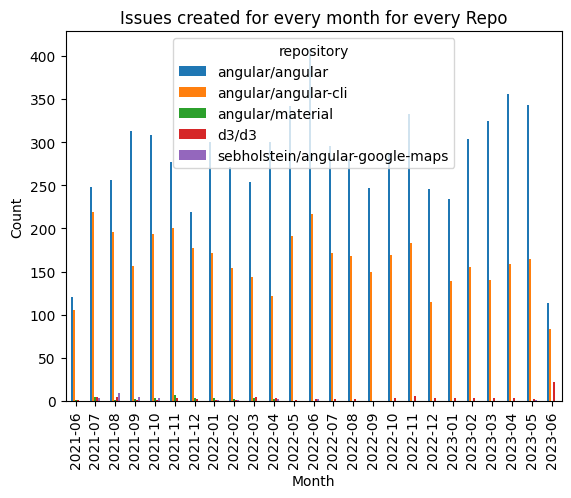

In [11]:
# A Bar Chart to plot the issues created for every month for every Repo
issues_monthly = issues_df.reset_index()

issues_monthly['Month'] = issues_monthly['issue.created_at'].dt.to_period('M')

# pivot table
issues_monthly_df = issues_monthly.pivot_table(index='Month', columns='repository', values='issue.created_at', aggfunc='count')

# bar chart
issues_monthly_df.plot(kind='bar', title='Issues created for every month for every Repo')

plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

<Axes: title={'center': 'Forks for every repo'}>

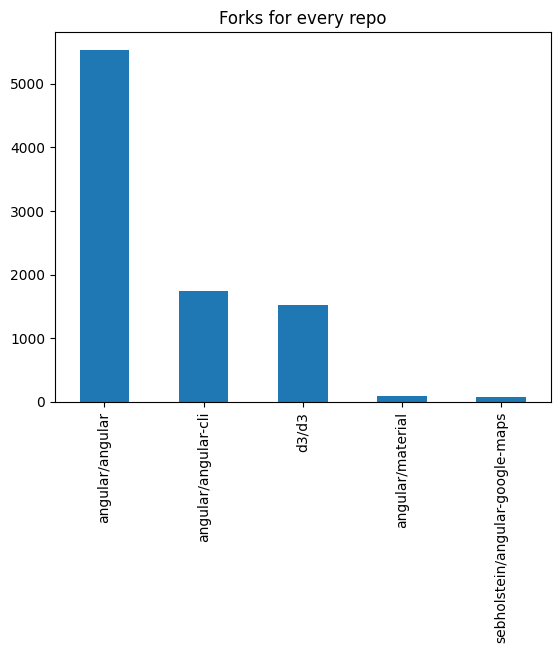

In [12]:
# convert list of forks to df
fork_data_df = pd.DataFrame(fork_data)

# count forks per repo
fork_count = fork_data_df['repository'].value_counts()
fork_count
# A Bar Chart to plot the forks for every Repo
fork_count.plot(kind='bar', x='repository', y='forks_count', title='Forks for every repo')

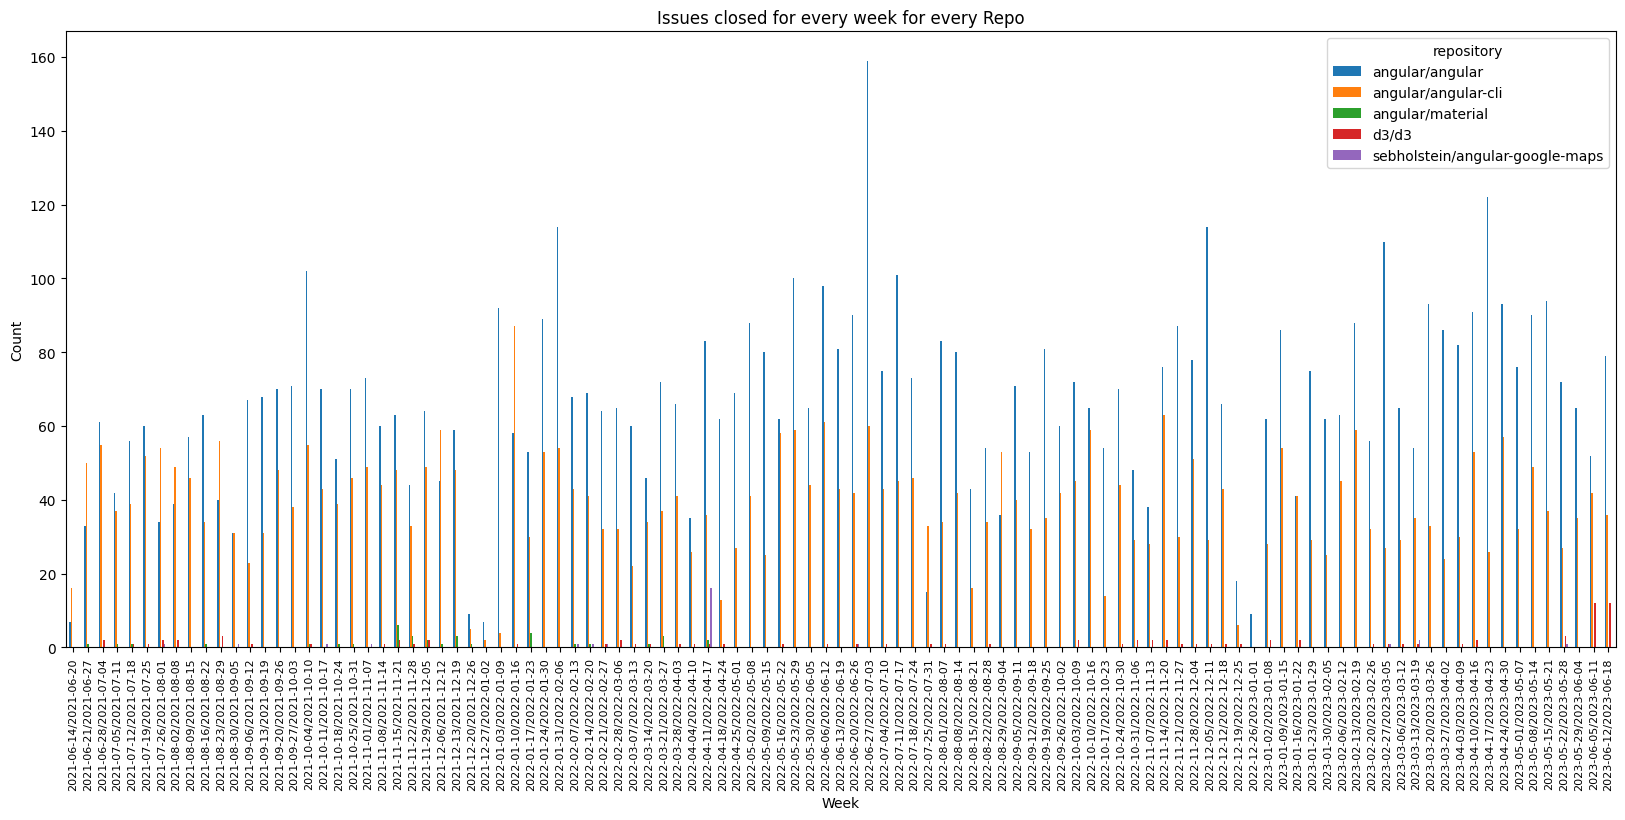

In [25]:
# A Bar Chart to plot the issues closed for every week for every Repo
issues_weekly = issues_df.reset_index()

issues_weekly['Week'] = issues_weekly['issue.closed_at'].dt.to_period('W')

# pivot table
issues_weekly_df = issues_weekly.pivot_table(index='Week', columns='repository', values='issue.closed_at', aggfunc='count')

# bar chart
issues_weekly_df.plot(kind='bar', title='Issues closed for every week for every Repo', figsize=(20,8))

plt.xticks(fontsize=8, rotation=90)
plt.xlabel('Week')
plt.ylabel('Count')
plt.show()

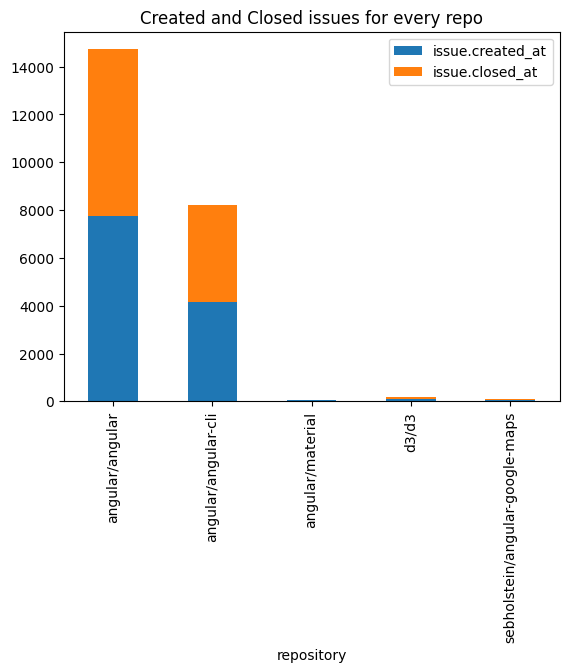

In [14]:
# convert to df
issues_df = pd.DataFrame(issues)

# convert created and closed columns to datetime
issues_df['issue.created_at'] = pd.to_datetime(issues_df['issue.created_at'])
issues_df['issue.closed_at'] = pd.to_datetime(issues_df['issue.closed_at'])

issues_count2 = issues_df.groupby('repository').count()

ax = issues_count2.plot(y=['issue.created_at', 'issue.closed_at'], kind='bar', stacked=True, title='Created and Closed issues for every repo')

plt.show()

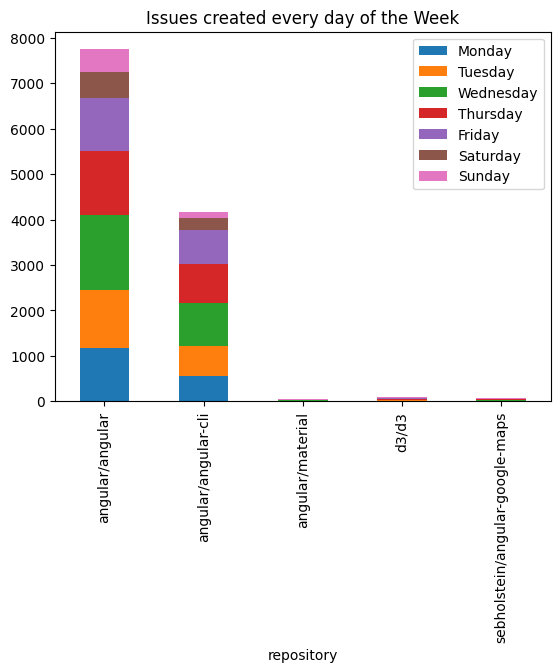

In [15]:
# A Stacked-Bar Chart to plot the total number of issues created every DAY of the Week (total on Mondays, Tuesdays, etc.) for all repos listed above.

# copy the df from earlier
issues_weekday = issues_df

# map date of issue creation to a weekday (0-6; 0=Monday)
issues_weekday['weekday'] = issues_df['issue.created_at'].dt.dayofweek

# get the count per weekday per repo
issues_weekday = issues_weekday.groupby(['repository', 'weekday']).size().unstack()
issues_weekday

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
labels = issues_weekday.plot(kind='bar', stacked=True, title='Issues created every day of the Week')
labels.legend(weekdays)

plt.show()

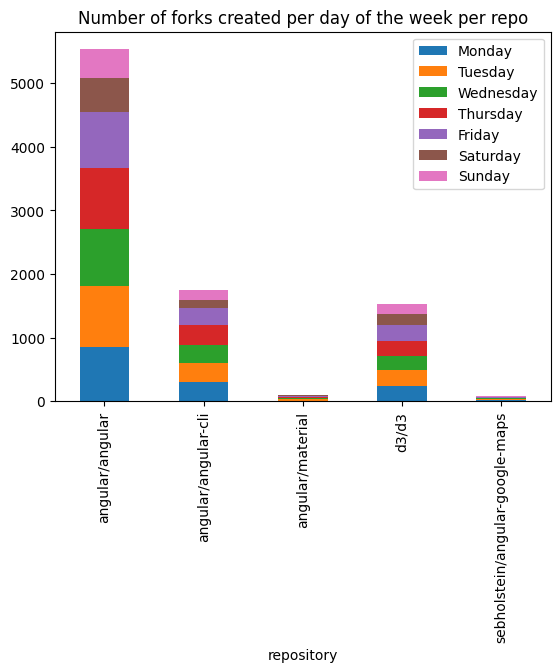

In [28]:
# convert to df
fork_data_df = pd.DataFrame(fork_data)

# map creation timestamp to weekday (0-6), count per weekday, store to fork_data_df_wd
fork_data_df['weekday'] = fork_data_df['created_at'].dt.dayofweek
fork_data_df_wd = fork_data_df.groupby(['repository', 'weekday']).size().unstack()

# A Stacked-Bar Chart to plot the total number of forks created every DAY of the Week (total on Mondays, Tuesdays, etc.) for all repos listed above.
forks_labeled = fork_data_df_wd.plot(kind='bar', stacked=True, title='Number of forks created per day of the week per repo')
forks_labeled.legend(weekdays)

# fork_data_df

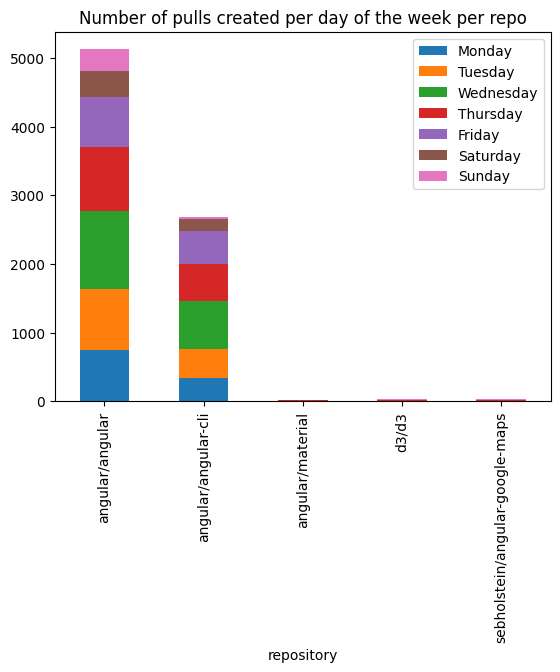

In [17]:
# convert pulls to df
pulls_df = pd.DataFrame(pulls)

# map creation timestamp to weekday (0-6), count per weekday, store to pulls_df_wd
pulls_df['weekday'] = pulls_df['pull.created_at'].dt.dayofweek
pulls_df_wd = pulls_df.groupby(['repository', 'weekday']).size().unstack()

# A Stacked-Bar Chart to plot the total number of pulls created every DAY of the Week (total on Mondays, Tuesdays, etc.) for all repos listed above.
pulls_labeled = pulls_df_wd.plot(kind='bar', stacked=True, title='Number of pulls created per day of the week per repo')
pulls_labeled.legend(weekdays)